In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
import seaborn as sns


In [9]:
#INITIALIZE CONSTANTS

# qed coupling
alpha = 1/129.0
# Z boson mass
Mz = 91.2
# Z decay width
Gammaz = 2.5
# qcd colors
Nc =3
# qcd light quark flavors
Nq = 5
# electric charge of electron
Qe = -1 
# electric charge of light up type quarks
Qu = 2.0/3.0
# electric charge of down quarks
Qd = -1.0/3.0
# weinberg angle function
sin2w = 0.223
# prefactor for chi functions
k = 1/(4*sin2w*(1-sin2w))

# weak isospin for down type and electros
T3e = -1.0/2.0
# weak isospin for up type (light)
T3u = 1.0/2.0
# conversion factor to picobars
F_conv = 3.89379656 * 10**8

# electron values
Ae = Af(T3e)
Ve = Vf(T3e, Qe)

# each step of the montecarlo has to choose one of the flavors randomly
# order in the arrays is important
quark_charges = np.asarray([Qu,Qd])
quark_isospin = np.asarray([T3u, T3e])



In [13]:
def Vf(Tf3, Qf):
    # calculates vector coupling for the f quark
    # args-> Tf3: scalar, weak isosipin of f quark.
    #        Qf: scalar, charge of f quark
    # returns vf: scalar, vector copuling
    
    return Tf3 - 2*Qf*sin2w

def Af(Tf3):
    # calculates axial coupling for the f quark
    # args-> Tf3: scalar, weak isosipin of f quark.
    # returns af: scalar, vector copuling
    
    return Tf3

def Chi1(s):
    return k*s*(s-Mz**2)/( (s-Mz**2)**2 + Gammaz**2*Mz**2)
    
def Chi2(s):
    return k*(s**2)/( (s-Mz**2)**2 + Gammaz**2*Mz**2)

def init_montecarlo(N_steps, s_constant=True):
    # initializes the values for the montecarlo integral
    
    # randomly generate the indices
    flavor_indices = np.random.randint(0,2, size=N_steps)

    # calculate the values for each step
    charge_sequence = np.asarray([quark_charges[x] for x in flavor_indices])
    isospin_sequence = np.asarray([quark_isospin[x] for x in flavor_indices])
    Aq_array = Af(isospin_sequence)
    Vq_array = Vf(isospin_sequence, charge_sequence)

    # draw random numbers for the integration
    if s_constant==True:
        s = Mz**2
        fs = 1
        
    costh = np.random.uniform(low=-1, high=1, size=(N_steps,))
    phi = np.random.uniform(low=0, high=2*np.pi, size=(N_steps,))

    return s, fs, costh, phi, Aq_array, Vq_array, charge_sequence


def diff_cross_section(s, costh, fs, Qq ,Aq, Vq):
    # evaluates the differential cross section at the given points
    # args-> s: array/scalar, random numbers for the s varialbe
    #        costh: array/scalar, random numbers following a cos distribution
    #        phi:   array/sacalar, random numbers for the angle phi
    # returns-> array: the differential cross section evaluated on the given points
    
    return fs*(1/(s*64*np.pi**2)) * ( (4*np.pi*alpha)**2*Nc*( (1+costh**2)*(Qe**2* Qq**2 \
                   + 2*Qe*Qq*Ve*Vq*Chi1(s) + (Ae**2+Ve**2)*(Aq**2 + Vq**2)*Chi2(s))\
                   + costh*( 4*Qe*Qq*Ae*Aq*Chi1(s) + 8*Ae*Ve*Aq*Vq*Chi2(s) ) ) )

                                   

## Problem 1: Fixed s

In [38]:

# integration values
N_montecarlo = 100000
benchmark_value = 42_250

In [39]:
# initialize the values
s, fs, costh, phi, Aq_array, Vq_array, charge_sequence = init_montecarlo(N_montecarlo)


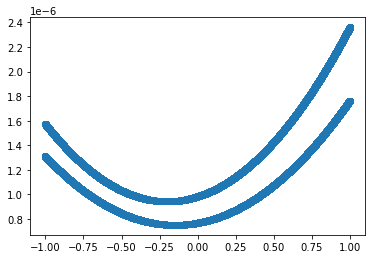

In [40]:
# calculate the cross section at several points
sigma_eval = diff_cross_section(s, costh, fs, 
                   charge_sequence ,Aq_array, Vq_array)

plt.scatter(costh,sigma_eval)

### Hit or miss

In [41]:
# calculate the cross section at several points
sigma_eval = diff_cross_section(s, costh, fs, 
                   charge_sequence ,Aq_array, Vq_array)

y_max = 10**(-5)
volume_interval = 2*y_max
phi_integral = 2*np.pi

y = y_max*np.random.rand(N_montecarlo)
accepted_points = y<=sigma_eval

# # perform the integration

sigma_res = phi_integral*Nq*volume_interval*(np.sum(accepted_points)/float(N_montecarlo))*F_conv
#sigma_res = phi_integral*Nq*volume_interval*(np.sum(sigma_eval[accepted_points])/np.sum(accepted_points))*F_conv

print('value = ', sigma_res)
print('true = ', benchmark_value)
print('error = ', np.abs(sigma_res-benchmark_value))
np.sum(sigma_eval[accepted_points])/np.sum(accepted_points)

value =  28497.350726136276
true =  42250
error =  13752.649273863724


1.276363311899322e-06

### Normal montecarlo 

In [43]:
# calculate the cross section at several points
sigma_eval = diff_cross_section(s, costh, fs, 
                   charge_sequence ,Aq_array, Vq_array)

volume_interval = 2
phi_integral = 2*np.pi
sigma_res = Nq*phi_integral*volume_interval*(np.mean(sigma_eval))*F_conv
montecarlo_uncertainty = 2 * np.sqrt( (np.mean(sigma_eval**2) - np.mean(sigma_eval)**2) 
                                     /float(N_montecarlo))*F_conv*Nq*phi_integral*volume_interval

print('value = ', sigma_res, 'with uncertainty = ', montecarlo_uncertainty)
print('true = ', benchmark_value)
print('error = ', np.abs(sigma_res-benchmark_value))


value =  28576.14901516183 with uncertainty =  54.65852158681944
true =  42250
error =  13673.85098483817


In [30]:
N_list = np.linspace(10, 10**6,30)

sigma_list = []
error_list = []
volume_interval = np.pi*2*np.pi

for n in N_list:
    # initialize the values
    s, fs, costh, phi, Aq_array, Vq_array, charge_sequence = init_montecarlo(n)
    # calculate the cross section at several points
    sigma_eval = diff_cross_section(s, costh, phi, fs, 
                   charge_sequence ,Aq_array, Vq_array)
    y_max = 10**(-3)
    volume_interval = 2*y_max

    y = y_max*np.random.rand(N_montecarlo)
    accepted_points = y<=sigma_eval
    
    # perform the integration
    sigma_res = 2*np.pi*Nq*volume_interval*(np.sum(accepted_points)/N_montecarlo)*F_conv
    error = np.abs(sigma_res-benchmark_value)
    
    sigma_list.append(sigma_res)
    error_list.append(error)
    

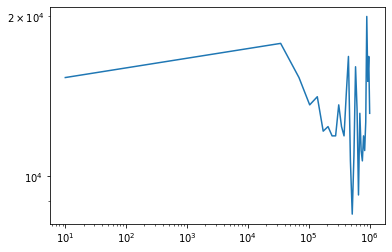

In [31]:
plt.loglog(N_list, error_list)

In [32]:
error_list

[15338.010131567738,
 17784.55466506158,
 15338.010131567738,
 13625.428958122051,
 14114.737864820818,
 12157.502238025747,
 12402.15669137513,
 11912.84778467636,
 11912.84778467636,
 13625.428958122051,
 12402.15669137513,
 11912.84778467636,
 14359.392318170205,
 16805.936851664046,
 10689.57551792944,
 8487.685437784981,
 10934.229971278823,
 16071.973491615892,
 13380.774504772664,
 9221.648797833135,
 13136.12005142328,
 11178.884424628206,
 10689.57551792944,
 11912.84778467636,
 11178.884424628206,
 12646.811144724514,
 19986.44474520604,
 15093.355678218351,
 16805.936851664046,
 13136.12005142328]

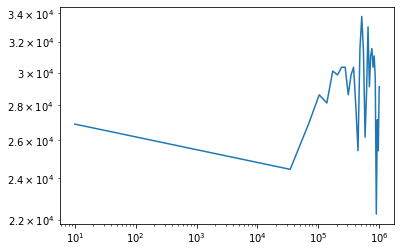

In [33]:
plt.loglog(N_list, sigma_list)

In [34]:
n=20000000
true_val = 2

volume = np.pi
random_theta = np.random.uniform(low=0, high=np.pi, size=(n,))
evaluated = np.sin(random_theta)

# hit or miss method
y_max = 1*np.random.rand()
accepted_points = evaluated <= ymax

res = volume*np.mean(evaluated)

print(res)
print(true_val)
np.abs(res - true_val)/true_val


NameError: name 'ymax' is not defined

In [ ]:
n=10**6

true_val = 0
evaluated = np.random.uniform(low=-1, high=1, size=(n,))
volume = 2

# hit or miss method
y_max = 1*np.random.rand()
accepted_points = evaluated <= ymax

res = 1*volume*np.sum(accepted_points)/n

print(res)
print(true_val)
np.abs(res - true_val)


In [ ]:
np.sum(accepted_points)/n

In [ ]:
np.power([3,2],2)
np.shape(x_list)

In [ ]:
y = func1(x_list)
y_mean = y[inside_domain].sum()/len(y[inside_domain])
res = y_mean * domain

res